## Read file after Factor Analysis

In [33]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

import math

import sys
import os
sys.path.append(os.path.abspath(".."))  
sys.path.append(os.path.abspath("./src")) 

from src.data_processing import get_outliers_df, merge_distance_column, process_lonely_observations, modify_species_id
from src.model import scale_features, find_lonely_observations, calculate_confusion_matrix_and_metrics
from src.visualization import plot_dendrogram_lonelylabels, plot_boxplot_with_outliers, plot_confusion_matrix


# Load file after Factor Analysis Steps
data_path = "../data/"
output_path = '../output/'

dataset ='Automatic_Labeling_Kyoogu/'
#dataset ='Dataset_1/'
#dataset ='Dataset_2/'

file = 'Reduced_dataframe_FA2.xlsx'
output_file = 'isolated_observations.xlsx'
df_reduced = pd.read_excel(data_path+dataset+file,index_col=0)
df_reduced



,Factor1,Factor2,Factor3,Length,DeltaFreq,Specie_ID
0,2313.651285,-0.810538,1.432301,1.999,2498.8,BOAN
1,2325.262738,-1.609512,1.109231,1.999,2498.0,BOAN
2,2416.875341,-0.602763,1.619106,1.999,2491.2,BOAN
3,2376.631380,0.325938,1.642970,1.999,2490.4,BOAN
4,2374.750540,-1.097416,0.829175,1.999,2487.2,BOAN
...,...,...,...,...,...,...
1377,11175.869674,12.269965,1.196414,1.999,6946.0,TRGL
1378,10992.311239,13.792381,0.348098,1.999,6989.2,TRGL
1379,10859.599210,19.086643,0.482057,1.999,6967.2,TRGL
1380,11302.587035,15.367604,1.975832,1.999,6956.4,TRGL


## Isolated observations and the percentage of them related to the dataset

In [34]:
only_features_scaled = scale_features(df_reduced) # Divide data in Features and Labels. Scale Featrues and convert to Data Frame with same index as df_reduced
lonely_observations, lonely_observations_df = find_lonely_observations(df_reduced, only_features_scaled) # Find isolated observations from 

#Calculate the percentage of "lonely" observations
num_lonely_observations = len(lonely_observations_df)
num_total_observations = len(df_reduced)
percentage_lonely = (num_lonely_observations / num_total_observations) * 100

# Display the result
print(f'\nThe total number of observations is: {num_total_observations}')
print(f'The number of lonely observations is: {num_lonely_observations}')
print(f"Percentage of lonely observations in relation with the Dataset: {percentage_lonely:.2f}%")




The total number of observations is: 1382
The number of lonely observations is: 108
Percentage of lonely observations in relation with the Dataset: 7.81%


In [35]:
lonely_observations_df.to_excel(output_path+dataset+output_file, index=False)
lonely_observations_df


,Lonely Index,Specie_ID,Nearest Same Label Index,Distance
0,511,DEND,514,3
1,1368,TRGL,1364,2
2,1364,TRGL,1368,2
3,1363,TRGL,1358,1
4,480,DEND,517,1
...,...,...,...,...
103,413,DDPX,357,10
104,905,FUSC,937,331
105,248,BOAN,97,1
106,423,DDPX,364,1


## Dendrogram of isolated observations.

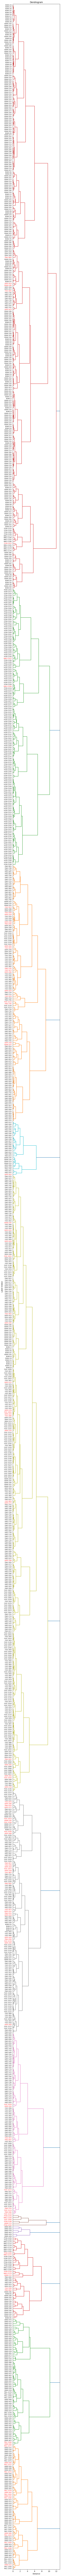

In [36]:
plot_dendrogram_lonelylabels(df_reduced, only_features_scaled, lonely_observations)

## Boxplots of isolated observations

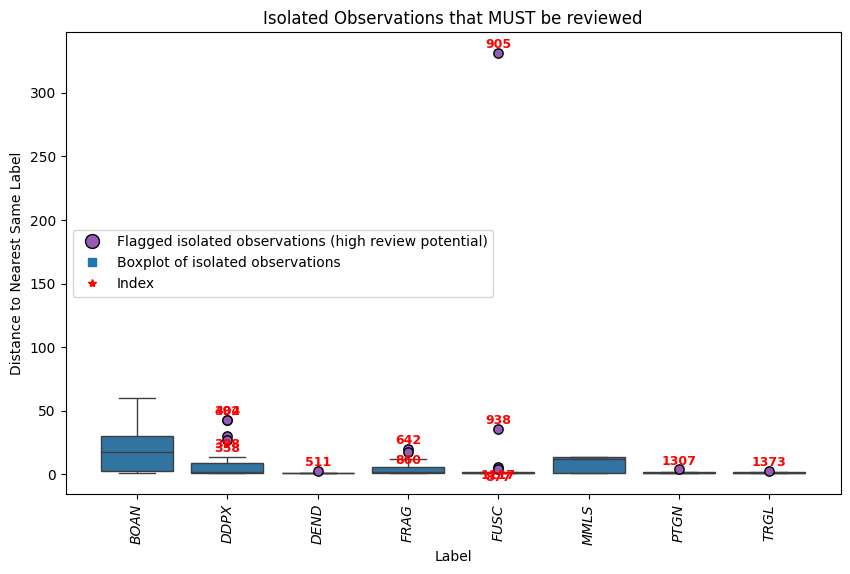

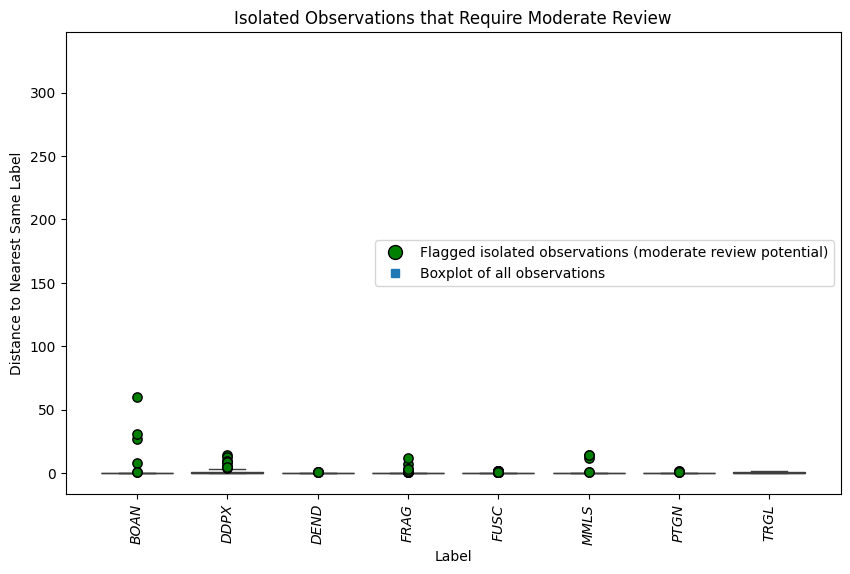

In [37]:
# Example usage for high and moderate review plots with custom boxplot legend text
data_full = merge_distance_column(df_reduced, lonely_observations_df )

observations_high_review_full = plot_boxplot_with_outliers(
    lonely_observations_df, 
    'Isolated Observations that MUST be reviewed', 
    '#975ab6', 
    'Flagged isolated observations (high review potential)', 
    'Boxplot of isolated observations', 
    show_annotations=True
)

# For the second plot, exclude the outliers from the first plot
observations_moderate_review_full = plot_boxplot_with_outliers(
    data_full, 
    'Isolated Observations that Require Moderate Review', 
    'green', 
    'Flagged isolated observations (moderate review potential)', 
    'Boxplot of all observations', 
    show_annotations=False,
    exclude_outliers_df=observations_high_review_full  # Exclude outliers from the first plot
)


observations_moderate_high_review_full = get_outliers_df(data_full)
# Exclude data that is already in observations_moderate_high_review
observations_low_review_full = lonely_observations_df.loc[:, ['Lonely Index', 'Distance', 'Specie_ID']]
observations_low_review_full = observations_low_review_full[
    ~observations_low_review_full.set_index(['Lonely Index', 'Distance', 'Specie_ID']).index.isin(
        observations_moderate_high_review_full.set_index(['Lonely Index', 'Distance', 'Specie_ID']).index
    )
]



In [38]:
percentage_moderate_high_review = (len(observations_moderate_high_review_full) / num_total_observations) * 100

# Print the results with the percentage in the same line
print(f"\nThe total number of observations is: {num_total_observations}")
print(f'The total number of isolated observations is: {num_lonely_observations}')
print(f"Percentage of lonely observations in relation with the Dataset: {percentage_lonely:.2f}%")
print("The observations flagged as high review potential are:", len(observations_high_review_full))
print("The ones flagged as moderate review potential are:", len(observations_moderate_review_full))
print(f"The observations flagged either as moderate or high review potential are: {len(observations_moderate_high_review_full)} "
      f"({percentage_moderate_high_review:.2f}% of total observations)")
print("Finally the observations with a low review potential are", len(observations_low_review_full))



The total number of observations is: 1382
The total number of isolated observations is: 108
Percentage of lonely observations in relation with the Dataset: 7.81%
The observations flagged as high review potential are: 13
The ones flagged as moderate review potential are: 67
The observations flagged either as moderate or high review potential are: 80 (5.79% of total observations)
Finally the observations with a low review potential are 28


# Create Pseudo Cleaning Dataset
by removing labels from the original dataset that are part of lonely labels.
Output: pseudo_clean_df

In [39]:
indices_to_remove = lonely_observations_df['Lonely Index']
pseudo_clean_df = df_reduced.drop(indices_to_remove)

### Compute false positives
False positives are isolated observations detected on pseudo clean dataset

In [40]:
only_features_scaled = scale_features(pseudo_clean_df)
lonely_observations_filtered, lonely_observations_filtered_df = find_lonely_observations(pseudo_clean_df, only_features_scaled)

(observations_high_review, observations_moderate_review, observations_moderate_high_review, observations_low_review) = process_lonely_observations(pseudo_clean_df, lonely_observations_filtered_df)

#Calculate the percentage of "lonely" observations
num_lonely_observations = len(lonely_observations_filtered_df)
num_total_observations = len(pseudo_clean_df)
percentage_lonely = (num_lonely_observations / num_total_observations) * 100

# Display the result}
# Print the results with the percentage in the same line
print(f"\nThe total number of observations of the Pseudo Clean Dataset is: {num_total_observations}")
print(f'The number of false positives is: {num_lonely_observations}')
print(f"Percentage of false positives in relation with the Pseudo Clean Dataset: {percentage_lonely:.2f}%")

# Compute the percentage for moderate-high review potential observations
percentage_moderate_high_review = (len(observations_moderate_high_review) / num_total_observations) * 100

print("\nThe observations flagged as HIGH review potential are:", len(observations_high_review))
print("The ones flagged as MODERATE review potential are:", len(observations_moderate_review))
print(f"The observations flagged either as MODERATE or HIGH review potential are: {len(observations_moderate_high_review)} "
      f"({percentage_moderate_high_review:.2f}% of total observations)")
print("Finally the observations with a LOW review potential are", len(observations_low_review))



The total number of observations of the Pseudo Clean Dataset is: 1274
The number of false positives is: 23
Percentage of false positives in relation with the Pseudo Clean Dataset: 1.81%

The observations flagged as HIGH review potential are: 1
The ones flagged as MODERATE review potential are: 22
The observations flagged either as MODERATE or HIGH review potential are: 23 (1.81% of total observations)
Finally the observations with a LOW review potential are 0


# Computing values on Artificially modified labels

In [41]:
# Apply the modification and get the modified DataFrame and modifications DataFrame
df_modified, modifications_df = modify_species_id(pseudo_clean_df, random_state=42)


### Reporting results of computed values over the artificially modified dataset

In [42]:
# Scale the features of the modified DataFrame
only_features_scaled = scale_features(df_modified)

# Find lonely observations in the modified DataFrame
lonely_observations, lonely_observations_modified_df = find_lonely_observations(df_modified, only_features_scaled)

(observations_high_review, observations_moderate_review, observations_moderate_high_review, observations_low_review) = process_lonely_observations(df_modified, lonely_observations_modified_df)

# Calculate the number of total observations and lonely observations
num_total_observations = len(pseudo_clean_df)
num_modified_indices = len(modifications_df)
num_lonely_observations = len(lonely_observations_modified_df)

# Calculate the percentage of lonely observations
percentage_lonely = (num_lonely_observations / num_total_observations) * 100
# Compute the percentage for moderate-high review potential observations
percentage_moderate_high_review = (len(observations_moderate_high_review) / num_total_observations)*100

# Display the results for lonely observations
print(f"The amount of artificially bad assigned labels is: {num_modified_indices}")
print(f"The TOTAL number of isolated observations detected by the method is: {num_lonely_observations} ({percentage_lonely:.2f}%)")

# Compute the percentage for moderate-high review potential observations
percentage_moderate_high_review = (len(observations_moderate_high_review) / num_total_observations) * 100

print("\nObservations flagged as HIGH review potential are:", len(observations_high_review))
print("Observations flagged as MODERATE review potential are:", len(observations_moderate_review))
print(f"The observations flagged either as MODERATE or HIGH review potential are: {len(observations_moderate_high_review)} "
      f"({percentage_moderate_high_review:.2f}%)")
print("Observations with a LOW review potential are", len(observations_low_review))

The amount of artificially bad assigned labels is: 127
The TOTAL number of isolated observations detected by the method is: 173 (13.58%)

Observations flagged as HIGH review potential are: 17
Observations flagged as MODERATE review potential are: 107
The observations flagged either as MODERATE or HIGH review potential are: 124 (9.73%)
Observations with a LOW review potential are 49


## Confusion Matrix of artificially modified labels

## K-fold validation for the method

### computed on all isolated observations

In [43]:
k = 10  # Number of folds

# Initialize lists to store the results
confusion_matrices = []
tp_list = []
fp_list = []
fn_list = []
tn_list = []

precision_list = []
recall_list = []
f1_score_list = []
accuracy_list = []

np.random.seed(42)
for fold_number in range(k):  
    random_state = np.random.choice(range(1, 51))
   
    # Apply modifications and process the data
    df_modified, modifications_df = modify_species_id(pseudo_clean_df, random_state=random_state)
    only_features_scaled = scale_features(df_modified)
    lonely_observations, lonely_observations_modified_df = find_lonely_observations(df_modified, only_features_scaled)
    (obs_H, obs_M, obs_MH, obs_L) = process_lonely_observations(df_modified, lonely_observations_modified_df)


    modified_indices_set = set(modifications_df['Index'])
    lonely_indices_set = set(lonely_observations_modified_df['Lonely Index'])
    #lonely_indices_set = set(obs_MH['Lonely Index'])
    total_indices = set(pseudo_clean_df.index)   

    # Calculate confusion matrix and metrics
    confusion_matrix, classification_metrics, cm, TP, FP, FN, TN = calculate_confusion_matrix_and_metrics(modified_indices_set, lonely_indices_set, total_indices)

    # Store the confusion matrix and metrics
    confusion_matrices.append(confusion_matrix)
    tp_list.append(TP)
    fp_list.append(FP)
    fn_list.append(FN)
    tn_list.append(TN)

    # Extract and store the precision, recall, f1-score, and accuracy for "Modified" class
    precision_list.append(classification_metrics['Modified']['precision'])
    recall_list.append(classification_metrics['Modified']['recall'])
    f1_score_list.append(classification_metrics['Modified']['f1-score'])
    accuracy_list.append(classification_metrics['accuracy'])





Average true positives across 10 folds: 120.100 ± 2.809
Average false positives 10 folds: 48.200 ± 2.182
Average false negatives across 10 folds: 6.900 ± 2.809
Average true negatives across 10 folds: 1098.800 ± 2.182
Average isolated observations detected: 168.3 ± 2.5

Average Precision across 10 folds: 0.714 ± 0.013
Average Recall across 10 folds: 0.946 ± 0.022
Average F1-Score across 10 folds: 0.813 ± 0.016
Average Accuracy across 10 folds: 0.957 ± 0.004

Average Confusion Matrix across all folds:


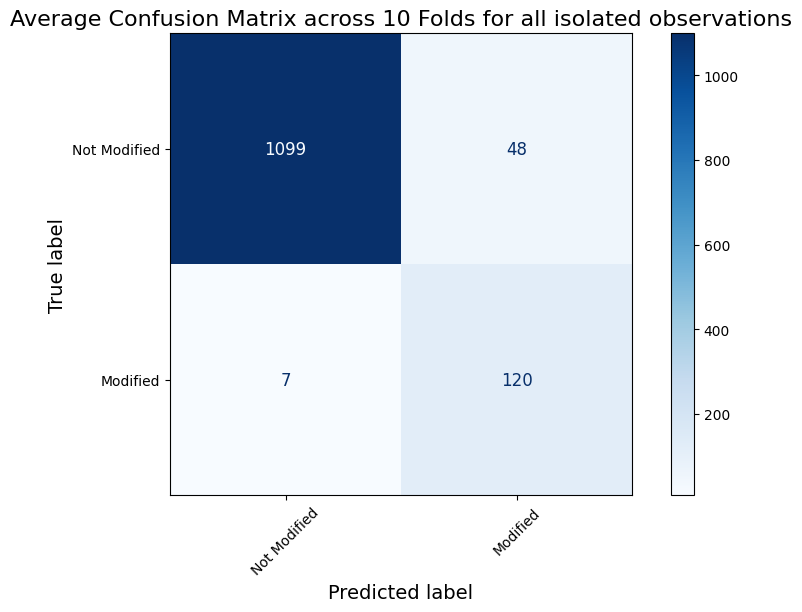

In [44]:
#Calculate average metrics across all folds
avg_tp = np.mean(tp_list)
avg_fp = np.mean(fp_list)
avg_fn = np.mean(fn_list)
avg_tn = np.mean(tn_list)

#Calculate standard deviation metrics across all folds
std_tp = np.std(tp_list)
std_fp = np.std(fp_list)
std_fn = np.std(fn_list)
std_tn = np.std(tn_list)

# Print the average metrics with standard deviation
print("\nAverage true positives across 10 folds: {:.3f} ± {:.3f}".format(avg_tp, std_tp))
print("Average false positives 10 folds: {:.3f} ± {:.3f}".format(avg_fp, std_fp))
print("Average false negatives across 10 folds: {:.3f} ± {:.3f}".format(avg_fn, std_fn))
print("Average true negatives across 10 folds: {:.3f} ± {:.3f}".format(avg_tn, std_tn))


# Calculate the sum of TP and FP for each fold (previously called lonely_observations)
lonely_obs_sum = np.array(tp_list) + np.array(fp_list)

# Calculate the average of the summed lonely observations
avg_lonely_obs_sum = np.mean(lonely_obs_sum)

# Calculate the standard deviation of the summed lonely observations
std_lonely_obs_sum = np.std(lonely_obs_sum, ddof=1)

# Calcular y mostrar el resultado con formateo
print(f"Average isolated observations detected: {avg_lonely_obs_sum:.1f} ± {std_lonely_obs_sum:.1f}")



# Calculate average precision, recall, f1-score, and accuracy
avg_precision = np.mean(precision_list)
avg_recall = np.mean(recall_list)
avg_f1_score = np.mean(f1_score_list)
avg_accuracy = np.mean(accuracy_list)

# Calculate standard deviation for each metric across all folds
std_precision = np.std(precision_list)
std_recall = np.std(recall_list)
std_f1_score = np.std(f1_score_list)
std_accuracy = np.std(accuracy_list)

# Print the average metrics with standard deviation
print("\nAverage Precision across 10 folds: {:.3f} ± {:.3f}".format(avg_precision, std_precision))
print("Average Recall across 10 folds: {:.3f} ± {:.3f}".format(avg_recall, std_recall))
print("Average F1-Score across 10 folds: {:.3f} ± {:.3f}".format(avg_f1_score, std_f1_score))
print("Average Accuracy across 10 folds: {:.3f} ± {:.3f}".format(avg_accuracy, std_accuracy))


# Calculate average confusion matrix
avg_confusion_matrix = pd.DataFrame({
    'Predicted Modified': [avg_tp, avg_fp],
    'Predicted Not Modified': [avg_fn, avg_tn]
}, index=['Actual Modified', 'Actual Not Modified'])


# Display the average confusion matrix
print("\nAverage Confusion Matrix across all folds:")
#print(avg_confusion_matrix)

# Prepare the confusion matrix for plotting (correct order)
cm = np.array([[avg_tn, avg_fp], [avg_fn, avg_tp]])
cm_rounded = np.round(cm)
cm_rounded = cm_rounded.astype(int)

plot_confusion_matrix(cm_rounded, title='Average Confusion Matrix across 10 Folds for all isolated observations')

1. Precision:
Intuition: Of all the times the model predicted positive, how many times was it correct?
2. Accuracy:
Intuition: Out of all the predictions the model made, how often did it predict correctly?
3. Recall (also known as Sensitivity):
Intuition: Of all the actual positive cases, how many did the model correctly identify?